In [57]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from collections import deque

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10089475750130877498
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9203229655
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10537347157608335599
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [25]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [27]:
import keras
import tensorflow as tf
config = tf.ConfigProto(
device_count = {'GPU': 1, 'CPU': 8}
)
sess = tf.Session(config = config)
keras.backend.set_session(sess)

In [3]:
import numpy as np
import pandas as pd
from operator import add
# colors = ['r', 'g', 'b', 'y']
colors = [1,2,3,4]

In [4]:
def new_board():
#     board = np.repeat([['e','e','e','e','e','e']], 12, axis = 0)
    board = np.repeat([[0, 0, 0, 0, 0, 0]], 12, axis = 0)
    return board

In [5]:
def get_next():
    f = colors[np.random.randint(0,4)]
    s = colors[np.random.randint(0,4)]
    return [f,s]
def get_col(co):
    co_i, co_j = co
    return board[co_i, co_j]
def fall(board):
    for col in range(len(board[0])):
        temp = board[:, col]
        temp = temp[temp != 0]
#         print(temp)
        board[:, col] = np.append(np.repeat([0], (len(board) - len(temp))), temp)

In [6]:
def pop(board, group):
    for i,j in group:
#         board[i, j] = 'e'------------------------------------------------------
       board[i, j] = 0 
    
def next_board(_board):
    board = _board.copy()
    visited = set()
    fall(board)
    fall(_board)
    
    def connect(i, j):
        current_color = board[i, j]
        current_group = {(i, j)}
        my_togo = {(i-1, j), (i+1, j), (i, j-1), (i, j+1)}
        new_togo = set()
        my_visited = {(i, j)}
        count = 1
        while len(my_togo) != 0:
            for r, c in my_togo:
                try:
                    if r >= 0 and c >= 0:
                        color = board[r][c]
                        my_visited.add((r, c))
                        if color == current_color:
                            count += 1
                            visited.add((r, c))
                            current_group.add((r, c))
                            adj = {(r-1, c), (r+1, c), (r, c-1), (r, c+1)}.difference(my_visited)
    #                         print(adj)
                            new_togo = new_togo.union(adj)
#                             print(new_togo)
                except:
                    continue
            my_togo = new_togo
            new_togo = set()
#             print(count)
            
        return count >= 4, current_group
    
    for i in range(len(board)):
            for j in range(len(board[0])):
#                 if board[i, j] != 'e' and (i, j) not in visited:---------------------------
                if board[i, j] != 0 and (i, j) not in visited:
                    chain, group = connect(i, j)
                    if chain:
                        pop(board, group)
#     print(visited)
    if np.array_equal(_board, board):
        return board, 0
    else:
#         return board
        nb, chain = next_board(board)
#         print(nb)
        return nb, chain+1

def hor(puyo, board, start):
    possible = []
    n, m = puyo
    for i in range(5):
#         if board[0][i] == 'e' and board[0][i + 1] == 'e':-----------------------------------------
        if board[0][i] == 0 and board[0][i + 1] == 0:
            t_board = board.copy()
            t_board = board.copy()
            t_board[0,i] = n
            t_board[0,i+1] = m
            possible.append((start + i, next_board(t_board)))
    return possible

def ver(puyo, board, start):
    possible = []
    n, m = puyo
    for i in range(6):
#         if board[0][i] == 'e' and board[1][i] == 'e':------------------------------------------
        if board[0][i] == 0 and board[1][i] == 0:
            t_board = board.copy()
            t_board[0,i] = n
            t_board[1,i] = m
            possible.append((start + i, next_board(t_board)))
    return possible

def possibleMove(next_puyo, board):
    possible = []
    possible.extend(hor(next_puyo[::], board, 0))
    possible.extend(hor(next_puyo[::-1], board, 5))
    possible.extend(ver(next_puyo[::], board, 10))
    possible.extend(ver(next_puyo[::-1], board, 16))
    return np.asarray(possible)

In [54]:
class DQNAgent(object):
    
    def __init__(self):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = deque(maxlen=2500)
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
#         self.model = self.network()
        self.model = self.network("weights.hdf5")
        self.epsilon = 0
        self.actual = []
        self.memory = []
        self.longest_chain = 0
        self.board = new_board()
        
    def set_state(self, board):
        self.board = board
        
    def set_reward(self, chains, over):
        if over:
            if self.longest_chain == 0:
                self.reward = -1e+4
            self.reward = -1e+3
        elif chains == 0:
            self.reward = 1
        elif chains > self.longest_chain:
            self.reward = 10**(chains-self.longest_chain)
            self.longest_chain = chains
        else:
            self.reward = 10
        return self.reward
    
    
    def network(self, weights=None):
        model = Sequential()
        model.add(Dense(output_dim=120, activation='relu', input_dim=72))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=120, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=120, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim=22, activation='softmax'))
        opt = Adam(self.learning_rate)
        model.compile(loss='mse', optimizer=opt)
        if weights:
            model.load_weights(weights)
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay_new(self, memory):
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
            
    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 72)))[0])
        target_f = self.model.predict(state.reshape((1, 72)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 72)), target_f, epochs=1, verbose=0)

In [59]:
print(4)

4


c:\users\kmkan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=72, units=120)`
c:\users\kmkan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
c:\users\kmkan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=120)`
c:\users\kmkan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=22)`


done


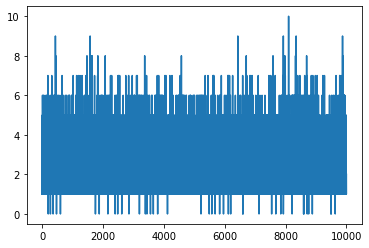

In [55]:
agent = DQNAgent()
chain_plot = []
counter_games = 0
for i in range(10000):
    board = new_board()
    done  = False
    max_chain = 0
#     while not done:
    for j in range(250):
        done = board[0][2] != 0
        agent.epsilon = 800 - counter_games
        
        state_old = board #agent.board
        
        puyos = get_next()
        possible = possibleMove(puyos, state_old)
        if len(possible) == 0: break
        possible_move = possible[::,0]
        wrong_move_penalty = 0
        
        if random.randint(0, 2000) < agent.epsilon:
            final_move = possible_move[random.randint(0, len(possible_move)-1)]
        else:
            prediction = agent.model.predict(state_old.reshape((1, 72)))
            final_move = to_categorical(np.argmax(prediction[0]))
            if final_move not in possible_move:
                final_move = possible_move[random.randint(0, len(possible_move)-1)]
#                     wrong_move_penalty = -10   
        state_new, chains = possible[possible[:, 0] == final_move][0][1]
    
        agent.longest_chain = chains if chains > agent.longest_chain else agent.longest_chain
        reward = agent.set_reward(chains, done) + wrong_move_penalty
        
        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)
        
        board = state_new
        counter_games += 1
        if chains > max_chain: max_chain = chains
    chain_plot.append(max_chain)
agent.model.save_weights('weights.hdf5')
plt.plot(chain_plot)
print('done')

44

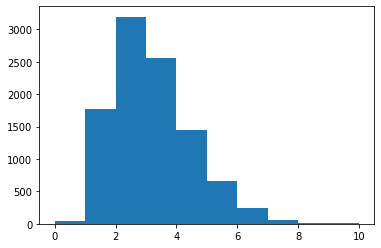

In [56]:
plt.hist(chain_plot, bins=10)
chain_plot.count(0)

In [78]:
a = get_next()
b = new_board()
possibleMove(a, b)[0]

array([0,
       (array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [3, 3, 0, 0, 0, 0]]), 0)], dtype=object)

In [20]:
r_board = board.copy()
r_board[len(r_board)-2, [0]] = 'r'
r_board[len(r_board)-2, [1]] = 'r'
r_board[len(r_board)-1, [0]] = 'r'
r_board[len(r_board)-1, [1]] = 'r'
# r_board[len(r_board)-2, [4]] = 'r'
# r_board[len(r_board)-2, [5]] = 'r'
# r_board[len(r_board)-1, [4]] = 'r'
# r_board[len(r_board)-1, [5]] = 'r'
r_board

array([['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['r', 'r', 'e', 'e', 'e', 'e'],
       ['r', 'r', 'e', 'e', 'e', 'e']], dtype='<U1')

In [21]:
f_board = board.copy()
f_board[len(r_board)-1, [0]] = 'r'
f_board[len(r_board)-2, [0]] = 'r'
f_board[len(r_board)-3, [0]] = 'r'

f_board[len(r_board)-1, [1]] = 'g'
f_board[len(r_board)-2, [1]] = 'g'
f_board[len(r_board)-3, [1]] = 'g'
f_board[len(r_board)-4, [1]] = 'r'

f_board[len(r_board)-1, [2]] = 'b'
f_board[len(r_board)-2, [2]] = 'b'
f_board[len(r_board)-3, [2]] = 'b'
f_board[len(r_board)-4, [2]] = 'g'

f_board[len(r_board)-1, [3]] = 'y'
f_board[len(r_board)-2, [3]] = 'y'
f_board[len(r_board)-3, [3]] = 'y'
f_board[len(r_board)-4, [3]] = 'b'

f_board[len(r_board)-1, [4]] = 'r'
f_board[len(r_board)-2, [4]] = 'r'
f_board[len(r_board)-3, [4]] = 'r'
f_board[len(r_board)-4, [4]] = 'y'

# f_board[len(r_board)-1, [5]] = 'r'
# f_board[0, [5]] = 'y'
# f_board[0, [4]] = 'r'

f_board

array([['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'r', 'g', 'b', 'y', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'e']], dtype='<U1')

In [5]:
k = np.array(['e', 'w'])
k[k != 'e']
# n = k[~np.all(k is 'e', axis = 0)]
# np.append(np.repeat(['e'], 3), np.array([2]))

array(['w'], dtype='<U1')

In [38]:
r_board[:,0]

'e'

In [37]:
def get_next():
    f = colors[np.random.randint(0,4)]
    s = colors[np.random.randint(0,4)]
    return [f,s]
def get_col(co):
    co_i, co_j = co
    return board[co_i, co_j]
def fall(board):
    for col in range(len(board[0])):
        temp = board[:, col]
        temp = temp[temp != 'e']
#         print(temp)
        board[:, col] = np.append(np.repeat(['e'], (len(board) - len(temp))), temp)

In [26]:
a = [1,2]
a[::-1]

[2, 1]

In [16]:
def hor(puyo, board, start):
    possible = []
    n, m = puyo
    for i in range(5):
        if board[0][i] == 'e' and board[0][i + 1] == 'e':
            t_board = board.copy()
            t_board = board.copy()
            t_board[0,i] = n
            t_board[0,i+1] = m
            possible.append((start + i, next_board(t_board)))
    return possible

def ver(puyo, board, start):
    possible = []
    n, m = puyo
    for i in range(6):
        if board[0][i] == 'e' and board[1][i] == 'e':
            t_board = board.copy()
            t_board[0,i] = n
            t_board[1,i] = m
            possible.append((start + i, next_board(t_board)))
    return possible

In [32]:
def possibleMove(next_puyo, board):
    possible = []
#     for i in range(5):
#         if board[0][i] == 'e' and board[0][i + 1] == 'e':
#             t_board = board.copy()
#             t_board[0][i] = next_puyo[0]
#             t_board[0][i+1] = next_puyo[1]
#             possible.add(next_board())
    possible.extend(hor(next_puyo[::], board, 0))
    possible.extend(hor(next_puyo[::-1], board, 5))
    possible.extend(ver(next_puyo[::], board, 10))
    possible.extend(ver(next_puyo[::-1], board, 16))
    return np.asarray(possible)
        

In [33]:
a = possibleMove(['r', 'r'], f_board)

In [52]:
# a[a[:,0] == 1][0][1][0]
b = new_board()
b[0][1]

'e'

In [49]:
def drop(board):
    fall(board)

In [15]:
def pop(board, group):
    for i,j in group:
        board[i, j] = 'e'
    
def next_board(_board):
    board = _board.copy()
    visited = set()
    fall(board)
    fall(_board)
    
    def connect(i, j):
        current_color = board[i, j]
        current_group = {(i, j)}
        my_togo = {(i-1, j), (i+1, j), (i, j-1), (i, j+1)}
        new_togo = set()
        my_visited = {(i, j)}
        count = 1
        while len(my_togo) != 0:
            for r, c in my_togo:
                try:
                    if r >= 0 and c >= 0:
                        color = board[r][c]
                        my_visited.add((r, c))
                        if color == current_color:
                            count += 1
                            visited.add((r, c))
                            current_group.add((r, c))
                            adj = {(r-1, c), (r+1, c), (r, c-1), (r, c+1)}.difference(my_visited)
    #                         print(adj)
                            new_togo = new_togo.union(adj)
#                             print(new_togo)
                except:
                    continue
            my_togo = new_togo
            new_togo = set()
#             print(count)
            
        return count >= 4, current_group
    
    for i in range(len(board)):
            for j in range(len(board[0])):
                if board[i, j] != 'e' and (i, j) not in visited:
#                     print(i, j)
                    chain, group = connect(i, j)
                    if chain:
                        pop(board, group)
#     print(visited)
    if np.array_equal(_board, board):
        return board, 0
    else:
#         return board
        nb, chain = next_board(board)
#         print(nb)
        return nb, chain+1
                    
   

In [32]:
next_board(f_board)

(array([['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'e', 'e', 'e', 'e', 'e'],
        ['e', 'r', 'g', 'b', 'y', 'e'],
        ['r', 'g', 'b', 'y', 'r', 'e'],
        ['r', 'g', 'b', 'y', 'r', 'e'],
        ['r', 'g', 'b', 'y', 'r', 'e']], dtype='<U1'), 0)

array([['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'r', 'e'],
       ['e', 'r', 'g', 'b', 'y', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'e'],
       ['r', 'g', 'b', 'y', 'r', 'y']], dtype='<U1')

In [10]:
def cal_next(position = None, _board):
    board = _board.copy()
    if not position:
        for i in range(len(board)):
            for j in range(len(board[0])):
                if board[i, j] != 'e':
                    return cal_next((i, j), board)
    else:
        c_i, c_j = position
        visited = {[c_i, c_j]}
        to_go = {[c_i, c_j]}
        while len(togo) != 0:
            
#     def walk():
    def connect(i, j):
        current_color = baord[i, j]
        current_group = {[i, j]}
        my_togo = {[i-1, j], [i+1, j], [i, j-1], [i, j+1]}
        new_togo = set()
        my_visited = {[i, j]}
        count = 1
        while len(my_togo) != 0:
            for r, c in my_togo:
                try:
                    color = board[r][c]
                    my_visited.add([r, c])
                    if color == current_color:
                        count += 1
                        visited.add([r, c])
                        current_group.add([r, c])
                        adj = {[r-1, c], [r+1, c], [r, c-1], [r, c+1]}.difference(my_visited)
                        new_togo.union({adj})
                except:
                    continue
            my_togo = new_togo
            new_togo = set()
        return count >= 4, current_group
        

IndentationError: expected an indented block (<ipython-input-10-ba719eddcc57>, line 15)

In [33]:
for i,j in [[1,2], [3,4]]:
    print(i, j)

1 2
3 4


In [46]:
a = {1,2,3}

In [43]:
a = np.array([[1,2], [3,4]])
max(a, key = lambda x: x[1])

array([3, 4])

In [48]:
a.add

{1, 2, 3, 4, 5, 6}

In [54]:
n = [1,2,3]
for i in range(3):
    try:
        for j in range(21):
            print(n[j])
    except:
        continue

1
2
3
1
2
3
1
2
3


In [52]:
{1,2,3}.difference({2})

{1, 3}

In [28]:
set([[2]])

TypeError: unhashable type: 'list'

In [126]:
n = np.array([1,2,3])

In [127]:
n.fill(2)

In [131]:
np.zeros(0)

array([], dtype=float64)

In [137]:
a = [3,4,5]

In [15]:
b = new_board()
b.reshape(1, 72)

72

array([['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e'],
       ['e', 'e', 'e', 'e', 'e', 'e']], dtype='<U1')